# Get the data

In [3]:
from ML_stock_price_pred.stock_data import StockData

In [25]:
ticker = 'NVDA'
start='2013-01-01'
end='2022-12-31'

In [26]:
NVDA = StockData(ticker, start, end)

[*********************100%%**********************]  1 of 1 completed


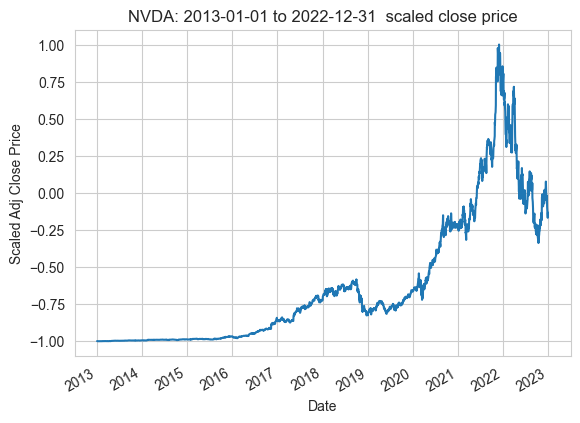

In [27]:
NVDA.plot_scaled_close()

In [28]:
X_train, y_train, X_test, y_test = NVDA.train_valid_split()

In [29]:
X_train.size()

torch.Size([1998, 20, 1])

In [30]:
train_df, test_df = NVDA.get_train_test_data_frame()
train_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,0
0,-0.998966,-0.998952,-0.998366,-0.998897,-0.999288,-0.999679,-0.999651,-0.999679,-0.999693,-1.000000,...,-0.999623,-0.999735,-0.999818,-0.999790,-0.999707,-0.999399,-0.999120,-0.999497,-0.999525,-0.999609
1,-0.998952,-0.998366,-0.998897,-0.999288,-0.999679,-0.999651,-0.999679,-0.999693,-1.000000,-0.999846,...,-0.999735,-0.999818,-0.999790,-0.999707,-0.999399,-0.999120,-0.999497,-0.999525,-0.999609,-0.999455
2,-0.998366,-0.998897,-0.999288,-0.999679,-0.999651,-0.999679,-0.999693,-1.000000,-0.999846,-0.999623,...,-0.999818,-0.999790,-0.999707,-0.999399,-0.999120,-0.999497,-0.999525,-0.999609,-0.999455,-0.999749
3,-0.998897,-0.999288,-0.999679,-0.999651,-0.999679,-0.999693,-1.000000,-0.999846,-0.999623,-0.999735,...,-0.999790,-0.999707,-0.999399,-0.999120,-0.999497,-0.999525,-0.999609,-0.999455,-0.999749,-0.999357
4,-0.999288,-0.999679,-0.999651,-0.999679,-0.999693,-1.000000,-0.999846,-0.999623,-0.999735,-0.999818,...,-0.999707,-0.999399,-0.999120,-0.999497,-0.999525,-0.999609,-0.999455,-0.999749,-0.999357,-0.999497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,-0.208493,-0.199167,-0.207892,-0.198096,-0.195167,-0.210670,-0.235984,-0.233478,-0.231002,-0.213160,...,-0.217160,-0.211198,-0.215379,-0.211741,-0.215002,-0.231244,-0.232180,-0.237840,-0.235229,-0.223002
1994,-0.199167,-0.207892,-0.198096,-0.195167,-0.210670,-0.235984,-0.233478,-0.231002,-0.213160,-0.210036,...,-0.211198,-0.215379,-0.211741,-0.215002,-0.231244,-0.232180,-0.237840,-0.235229,-0.223002,-0.228481
1995,-0.207892,-0.198096,-0.195167,-0.210670,-0.235984,-0.233478,-0.231002,-0.213160,-0.210036,-0.217160,...,-0.215379,-0.211741,-0.215002,-0.231244,-0.232180,-0.237840,-0.235229,-0.223002,-0.228481,-0.224949
1996,-0.198096,-0.195167,-0.210670,-0.235984,-0.233478,-0.231002,-0.213160,-0.210036,-0.217160,-0.211198,...,-0.211741,-0.215002,-0.231244,-0.232180,-0.237840,-0.235229,-0.223002,-0.228481,-0.224949,-0.207364


# Build the model

In [49]:
import torch
from torch import nn
from torchinfo import summary

In [41]:
class RNNModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=32, layer_dim=2, output_dim=1, dropout_prob=0):
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (seq_length, batch_size, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [42]:
# define model params
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1

rnn_model = RNNModel(input_dim, hidden_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(rnn_model.parameters(), lr=0.01)

In [50]:
summary(rnn_model)

Layer (type:depth-idx)                   Param #
RNNModel                                 --
├─RNN: 1-1                               3,232
├─Linear: 1-2                            33
Total params: 3,265
Trainable params: 3,265
Non-trainable params: 0

# Train

In [43]:
import time
import numpy as np

In [44]:
# train
num_epochs = 200

hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = rnn_model(X_train)

    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time    
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.4197932183742523
Epoch  1 MSE:  0.04245397821068764
Epoch  2 MSE:  0.2804294526576996
Epoch  3 MSE:  0.056357428431510925
Epoch  4 MSE:  0.06956570595502853
Epoch  5 MSE:  0.11867254227399826
Epoch  6 MSE:  0.09885731339454651
Epoch  7 MSE:  0.05952024459838867
Epoch  8 MSE:  0.03493106737732887
Epoch  9 MSE:  0.037328317761421204
Epoch  10 MSE:  0.05296133831143379
Epoch  11 MSE:  0.054524220526218414
Epoch  12 MSE:  0.04162197560071945
Epoch  13 MSE:  0.033179428428411484
Epoch  14 MSE:  0.0369025282561779
Epoch  15 MSE:  0.0437798947095871
Epoch  16 MSE:  0.043872494250535965
Epoch  17 MSE:  0.0377066470682621
Epoch  18 MSE:  0.031469255685806274
Epoch  19 MSE:  0.029339782893657684
Epoch  20 MSE:  0.030800525099039078
Epoch  21 MSE:  0.032095618546009064
Epoch  22 MSE:  0.030359286814928055
Epoch  23 MSE:  0.02666437439620495
Epoch  24 MSE:  0.024328239262104034
Epoch  25 MSE:  0.02473447658121586
Epoch  26 MSE:  0.0257109384983778
Epoch  27 MSE:  0.024334989488124

# Visualization of train and test

In [45]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Train')

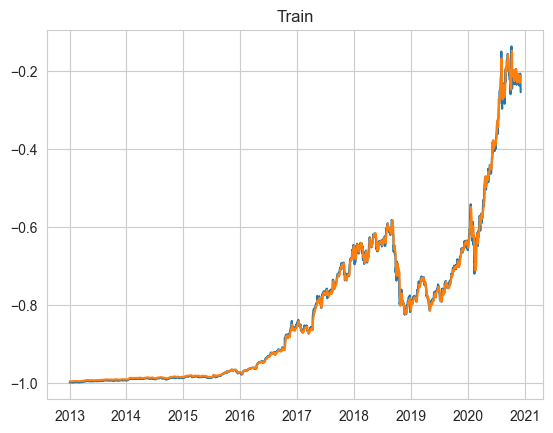

In [46]:
price = NVDA.data
n_train = len(X_train)

fig1, ax1 = plt.subplots()
ax1.plot(price.index[0:n_train], y_train.detach().numpy())
ax1.plot(price.index[0:n_train], y_train_pred.detach().numpy())
ax1.set_title('Train')

In [47]:
y_test_pred = rnn_model(X_test)

Text(0.5, 1.0, 'Test')

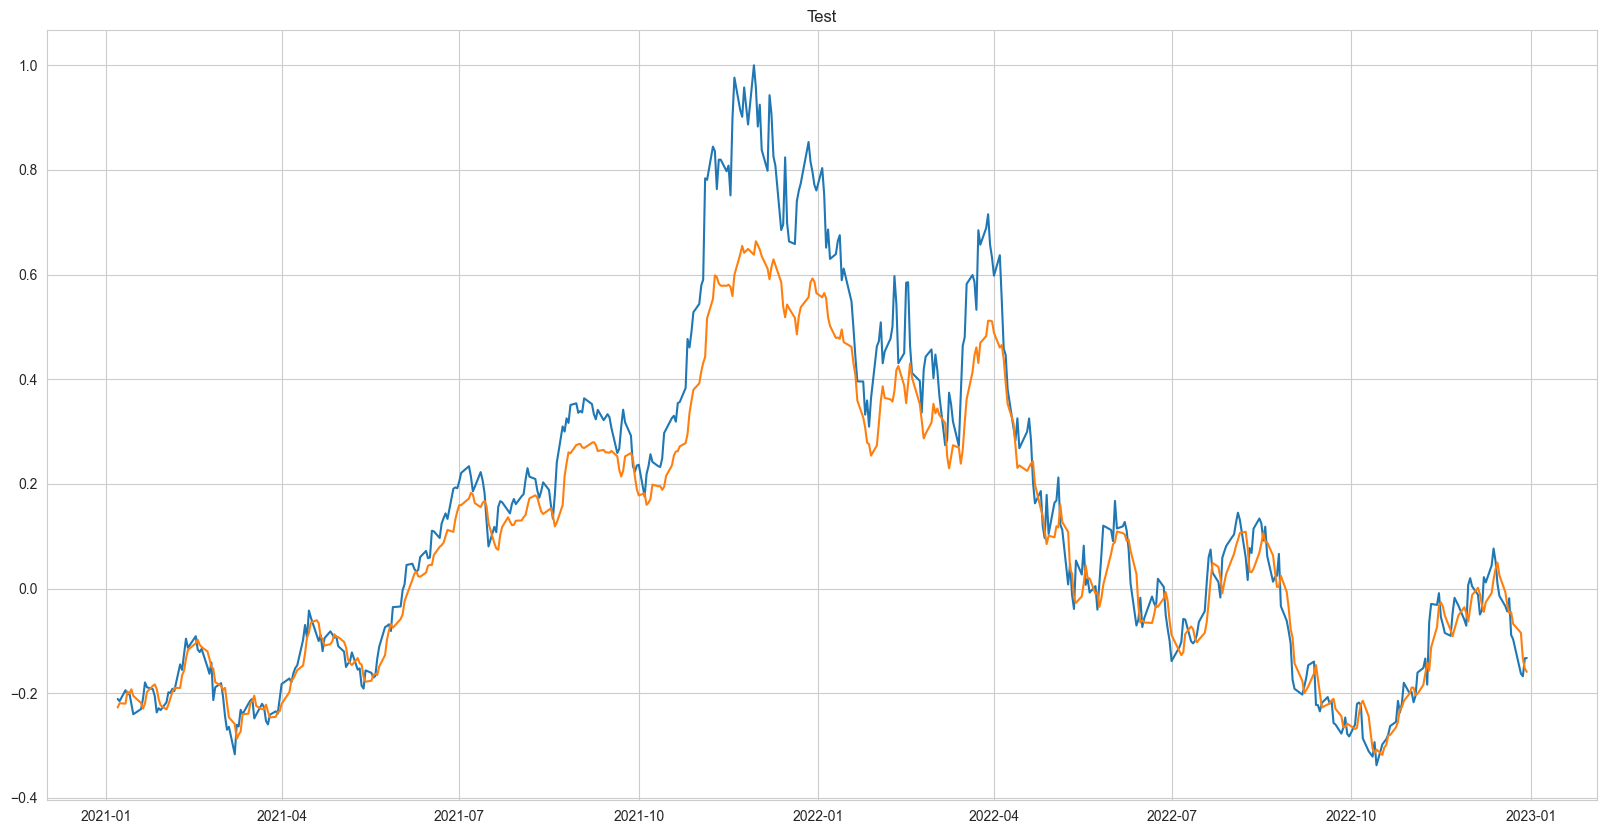

In [48]:
lookback = 20
fig2, ax2 = plt.subplots(figsize=(20, 10))
ax2.plot(price.index[n_train+lookback:], y_test.detach().numpy())
ax2.plot(price.index[n_train+lookback:], y_test_pred.detach().numpy())
ax2.set_title("Test")